<a href="https://colab.research.google.com/github/tetianafesenko/Assignment-4---VI/blob/main/Tetiana_Fesenko__FeedforwardNN_spirals_pytorch_HW4Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW4, Problem 2: Feedforward neural networks in PyTorch

April 10, 2023

Original code by Lauren Hayward, Juan Carrasquilla and Mohamed Hibat Allah (2022), modified by Andrew Jreissaty for the 2023 iteration of the Caregivers and Machine Learning course.

**Objective of this problem**: *to become comfortable with using the Python package PyTorch to create and train a simple feedforward neural network for supervised learning.* <u>Remark:</u> Apart from the comments that explain the code itself, look out for the comments in the code that are there to guide you for specific parts of this problem. These comments should hopefully stand out.

**Part (a):** Run the code and look at how it attempts to classify the two-dimensional space. You should find that the resulting classifier separates the two-dimensional space using lines, and thus does a poor job of representing the data. You don't need to understand every line of code. But feel free to ask me (Andrew) if you have questions about the details!

**Part (b):** Look through the section of code labelled "Define the network architecture". On paper, draw the neural network corresponding to the one in the code for the case of K=3 branches (labels). Pay particular attention to the number of neurons in each layer. 

**Part (c):** Add in a hidden layer with 4 neurons and study how this hidden layer changes the output. On paper, draw the neural network in this case.

**Part (d):** Replace the activation function in the first layer with a sigmoid and then a rectified linear unit (ReLU). Discuss how the choice of activation function changes your results.

**Part (e):** Study the effects of increasing and decreasing the learning rate hyperparameter. Provide short comment on what you notice.

**Part (f):** Here you will plot accuracy of the final trained (optimized) neural network (with one hidden layer) as a function of three changing hyperparameters:

> **Hyperparameter 1**: mag_noise (the magnitude of noise in the data) - the code is already written here, you just need to tweak one line of code to include the hidden layer (instructions for this should be clear!) and then run it.

> **Hyperparameter 2**: number of neurons in the hidden layer - you will need to copy paste the code used for mag_noise and tweak relevant lines of code to plot accuracy vs number of hidden neurons. If in doubt, start with 1 hidden neuron and then increase to about 8 or 9 in increments of 1.

> **Hyperparameter 3 (BONUS)**:   K (the number of different labels) - again, you will need to copy paste the code used for mag_noise and tweak relevant lines of code to plot accuracy vs K. This is a bonus question. If in doubt, you can start from K = 2 (K = 1 is trivial) to about 6 or 7 in increments of 1.

<u>FINAL REMARK:</u> If you feel that your network is not converging in any of the above questions, go ahead and increase N_epochs (the number of training steps, as you will see in the code below) to see if you achieve better convergence (for example if N_epochs = 10000 doesn't quite cut it for a given set of hyperparameters, maybe try N_epochs = 20000 or 15000 and see if that works better). Also, while you will need to play with the learning rate in part(e) above, feel free to modify the learning rate for all the other parts of this problem to try to achieve better convergence (the default value we select in the code is learning_rate = 1; this should work well enough but feel free to play with it).

**NOTE I: <font color='green'>Green comments</font> in the code are there as explanation / clarification of the details of the code**

**NOTE II: <font color='red'>Red comments</font> in the code that start with "Q2c:", "Q2d:", "Q2e:", "Q2f:" are there as specific guidance/instructions for parts(c) through (f) of the problem**

Import all of your required libraries. If you run into problems where the error you get is of the form,

*ModuleNotFoundError: No module named '*module_name*'

then you will need to add an additional block above your imports with the following command:


> !pip install *missing_module*

In [3]:
# import the necessary libraries and packages
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from IPython import display
import time
import torch

## Create and plot the data set


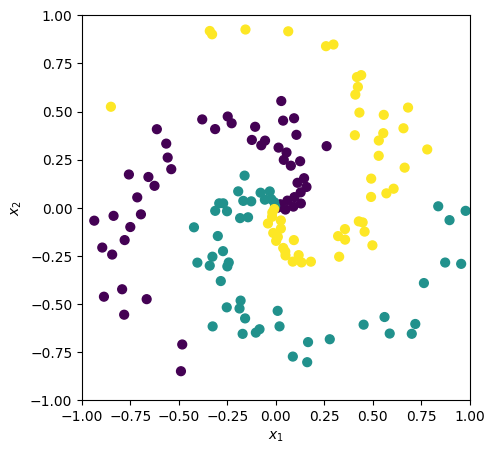

In [4]:
############ Function for data generation: ############
def dataGeneration(N,K,mag_noise,dTheta):
    '''
    FUNCTION INPUTS
    N         --> number of points per branch / class
    K         --> number of branches / classes
    mag_noise --> controls how much noise gets added to the data
    dTheta    --> difference in theta (angle) in each branch
    '''
    N_train = N*K # total number of points in the training set

    # Initialization of numpy arrays we will need
    x_train = np.zeros((N_train,2)) # matrix containing the 2-dimensional datapoints
    t_train = np.zeros(N_train, dtype='uint8') # labels (not in one-hot representation)

    # Looping over the branches (We use polar coordinates to generate the data points)
    for j in range(K):
        ix = range(N*j,N*(j+1))
        r  = np.linspace(0.01,1,N) # radius
        th = np.linspace(j*(2*np.pi)/K,j*(2*np.pi)/K + dTheta,N) + np.random.randn(N)*mag_noise # theta
        x_train[ix] = np.c_[r*np.cos(th), r*np.sin(th)]
        t_train[ix] = j

    return x_train, t_train # return data points and associated labels
############ End of data generation function: ############


### Generate 2-dimensional data points ###
N = 50 # number of points per branch/class
K = 3 # number of branches i.e. classes
mag_noise = 0.3 
dTheta    = 4
x_train, t_train = dataGeneration(N,K,mag_noise,dTheta)

### Plot the data set: ###
fig = plt.figure(1, figsize=(5,5))
plt.scatter(x_train[:, 0], x_train[:, 1], c=t_train, s=40)#, cmap=plt.cm.Spectral)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.savefig('spiral_data.pdf', bbox_inches="tight",dpi=500)
plt.show()

In [3]:
#Run this cell if you want to save a pdf plot of the dataset:
files.download('spiral_data.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Define the network architecture

In [5]:
import torch
import torch.nn as nn

'''
GENERAL INSTRUCTIONS FOR HIDDEN LAYER INCLUSION.

For Q2 Part(c) (adding a hidden layer), You will need to:

  -Add an additional variable that contains the size of the hidden layer (hidden_size) as an argument to the __init__ function alongside input_size, etc.

  -Define an additional attribute of the class (technically of the object of the class that will be created) that will store hidden_size
      e.g. the line "self.input_size = input_size" that you see below takes the input_size argument that was fed into the initialization function and
      stores it within an attribute of the class that we are calling "self.input_size". Write the analogous code for hidden_size in the specified position
      (see below).

  -You will need to define a second linear transformation object called self.linear2 which will correspond to the hidden layer.
      For this uncomment the relevant line of code below (it should be clear) and add the two correct arguments for the initialization of the object.
  
  -You will also need to modify the second argument of self.linear1 - remember the output of one layer must be the inputs to the next layer.

  -Add code underneath "Layer 2" below that corresponds to the linear transformation performed in the hidden layer.
      This is analogous to what is done underneath "Layer 1", but requires some slight tweaking.
'''

class FeedforwardNN(torch.nn.Module):
    '''Q2c: Include additional argument/input to __init__ function corresponding to size of hidden layer. You can call it hidden_size'''
    def __init__(self, input_size, output_size):
        # The __init__ function is called every time an object of a class (or instance of the class) is created. This function essentially takes in
        # arguments or inputs and uses them to initialize the object, its attributes and methods.

        super(FeedforwardNN, self).__init__()

        ### Define attributes of the object of the class (i.e. instance of the class) that is being created. self just represents this object ###
        #layer sizes:
        self.input_size = input_size
        self.output_size = output_size
        '''Q2c: Define additional attribute of the class here, i.e. self.[attribute_name], corresponding to the size of your hidden layer.
                Use self.input_size and self.output_size above as a template for how to do this'''
        
        self.linear2 = torch.nn.Linear(self.hidden_size, self.output_size)


        ### Functions used within the Feedforward NN ###
        '''Q2c: Modify the second argument of the torch.nn.Linear class on the right-hand side of the below definition of self.linear1 when the
                hidden layer is added. Recall, the outputs of each layer are the inputs to the next layer, and we want self.output_size to refer
                to the size of the FINAL output layer of the entire network '''
        
        self.linear1 = torch.nn.Linear(self.input_size, self.output_size)
        self.linear1 = torch.nn.Linear(self.input_size, self.hidden_size)
                                                                          # First argument = size of input to linear transformation
                                                                          # Second argument = size of output of the linear transformation
                                                                          # Note: when the hidden layer is added, change the second argument.

        '''Q2c: Uncomment the line below AND include the two correct arguments to the torch.nn.Linear() class when hidden layer is added.
                The first argument should be the size of the input to the hidden layer, the second argument should be the size of the
                output of the layer'''
        self.linear2 = torch.nn.Linear(argument_1,argument_2) 
        self.relu    = torch.nn.ReLU() 
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax()    

    def forward(self, x):
        #Layer 1:
        linear1_out = self.linear1(x)  # Linear transformation
        h1 = self.softmax(linear1_out) # Nonlinear activation function
        '''Q2d: Once the hidden layer is added in Q2c, Layer 1 now corresponds to the hidden layer. The softmax activation function for Layer 1
                (i.e. the hidden layer) will need modification for part (d), where you are asked to try the sigmoid and ReLU activation. For part(f),
                feel free to have any activation function here (softmax, sigmoid or ReLU), but I say go ahead and choose either the sigmoid or ReLU
                function. Part(e), where you change learning_rate, can be done with any activation function as well'''

        #Layer 2:
        '''Q2c: once you decide to add a hidden layer, Layer 1 actually becomes the hidden layer. The idea is you want the outputs of the hidden layer
                (i.e. Layer 1) to be the inputs to the final output layer (i.e. Layer 2). So add code here that corresponds to the linear transformation
                for the final output layer, analogous to the #Layer 1 code that is written above.
                
                Be careful about the argument of self.linear2 (Hint: it will not be x).
                Also: ensure the nonlinear activation function for this layer is always softmax'''

        #Network output:
        y = h1
        '''Q2c: once hidden layer is added, make sure that y equals the output of the overall NN (i.e. the output of the final output layer, Layer 2)'''

        return y

### Initialize the model ### (we could initialize it here, but we actually end up doing it later for reasons we can discuss if you are interested)
#input_size = 2 # dimension of input
#output_size = K # dimension of output
#model = FeedforwardNN(input_size, output_size)

### Store the input data as a PyTorch tensor ###
x_train = torch.tensor(x_train, dtype = torch.float)

### One hot encoding ###
t_onehot = np.zeros((t_train.size, K))
t_onehot[np.arange(t_train.size),t_train] = 1
t_onehot = torch.tensor(t_onehot, dtype = torch.float)

### Cost function (which we want to minimize) ###
cost_func = torch.nn.CrossEntropyLoss()

## Define the dynamic plotting function

In [6]:
############ Function for plotting: ############
def updatePlot(model,x_train,t_train,epoch_list,cost_training,acc_training):
    '''
    FUNCTION INPUTS:
    model         --> feedforward neural network (instance of the FeedforwardNN class)
    x_train       --> matrix containing 2-dimensional data points
    t_train       --> labels (not in one-hot representation)
    epoch_list    --> list that stores the epoch numbers to be plotted
    cost_training --> list that stores training cost values associated with each epoch in epoch_list
    acc_training  --> list that stores training accuracy values associated with each epoch in epoch_list
    '''
    ### Generate coordinates covering the whole plane: ###
    padding = 0.1
    spacing = 0.02
    x1_min, x1_max = x_train[:, 0].min() - padding, x_train[:, 0].max() + padding
    x2_min, x2_max = x_train[:, 1].min() - padding, x_train[:, 1].max() + padding
    x1_grid, x2_grid = np.meshgrid(np.arange(x1_min, x1_max, spacing),
                         np.arange(x2_min, x2_max, spacing))

    torch_input = torch.tensor(np.c_[x1_grid.ravel(), x2_grid.ravel()], dtype = torch.float)
    NN_output = model(torch_input)
    predicted_class = np.argmax(NN_output.detach().numpy(), axis=1)

    ### Plot the classifier: ###
    plt.subplot(121)
    plt.contourf(x1_grid, x2_grid, predicted_class.reshape(x1_grid.shape), K, alpha=0.8)
    plt.scatter(x_train[:, 0], x_train[:, 1], c=t_train, s=40)
    plt.xlim(x1_grid.min(), x1_grid.max())
    plt.ylim(x2_grid.min(), x2_grid.max())
    plt.xlabel(r'$x_1$')
    plt.ylabel(r'$x_2$')

    ### Plot the cost function during training: ###
    plt.subplot(222)
    plt.plot(epoch_list,cost_training,'o-')
    plt.xlabel('Epoch')
    plt.ylabel('Training cost')

    ### Plot the training accuracy: ###
    plt.subplot(224)
    plt.plot(epoch_list,acc_training,'o-')
    plt.xlabel('Epoch')
    plt.ylabel('Training accuracy')
############ End of plotting function ############

## Define the training function

In [7]:
############ Function for training: ############
def training(model,x_train,t_train,t_onehot,N_epochs,learning_rate,dynamicPlotting_YesOrNo):
    '''
    FUNCTION INPUTS:
    model                   --> feedforward neural network (instance of the FeedforwardNN class)
    x_train                 --> matrix containing the 2-dimensional data points
    t_train                 --> labels (not in one-hot representation)
    t_onehot                --> one-hot encoding of t_train values labels. The
    N_epochs                --> number of times to run gradient descent (i.e. number of training steps)
    learning_rate           --> learning rate
    dynamicPlotting_YesOrNo --> 1 or 0. If this is 1, then plot dynamically as the training process unfolds. If this is 0, no plotting is done.
    '''
    ### Use backpropagation to minimize the cost function using the gradient descent algorithm: ###
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # model.parameters() = all the weights of the neural network
                                                                      # These will be updated during the Stochastic Gradient Descent (SGD)
                                                                      # training process.

    ### Initialization of lists we need ###
    epoch_list    = [] # Will store the desired epoch numbers
    cost_training = [] # Will store the training cost associated with each epoch in epoch_list 
    acc_training  = [] # Will store the training accuracy associated with the epoch in epoch_list

    ### Train for N_epochs epochs ###
    for epoch in range(N_epochs+1):
        optimizer.zero_grad() # sets the gradients to zero (necessary since PyTorch accumulates the gradients)
        NN_output = model(x_train) # Neural network output
        cost = cost_func(NN_output, t_onehot)
        cost.backward() #computes the gradients
        optimizer.step() #updating the parameters 

        ### Update the plot and print results every 500 epochs: ###
        if epoch % 500 == 0:
            predicted_class = np.argmax(NN_output.detach().numpy(), axis=1)
            accuracy = np.mean(predicted_class == t_train)

            epoch_list.append(epoch)
            cost_training.append(cost.detach().numpy())
            acc_training.append(accuracy)

            ### Update the plot of the resulting classifier if and only if dynamicPlotting_YesOrNo == 1 ###
            if dynamicPlotting_YesOrNo == 1:
                fig = plt.figure(2,figsize=(10,5))
                fig.subplots_adjust(hspace=.3,wspace=.3)
                plt.clf()
                updatePlot(model,x_train,t_train,epoch_list,cost_training,acc_training)
                display.display(plt.gcf())
                
            print("Iteration %d:\n  Training cost %f\n  Training accuracy %f\n" % (epoch, cost, accuracy))
            display.clear_output(wait=True) # clear output every 500 training steps to be able to display new ouput
            
            #time.sleep(0.1) #Uncomment this line if you want to slow down the rate of plot updates

    ### Define and output the final cost and final accuracy after training for (N_epochs+1) epochs
    final_cost = cost.detach().numpy()                              # cost is the final value of the training cost that was computed in the above loop
    predicted_class = np.argmax(NN_output.detach().numpy(), axis=1) # NN_output is the final value of NN_output computed in the above loop
    final_accuracy = np.mean(predicted_class == t_train)

    return final_cost, final_accuracy # output final cost, final accuracy 
############ End of training function ############

## Training

Final Training cost 0.010720
Final Training accuracy 1.000000



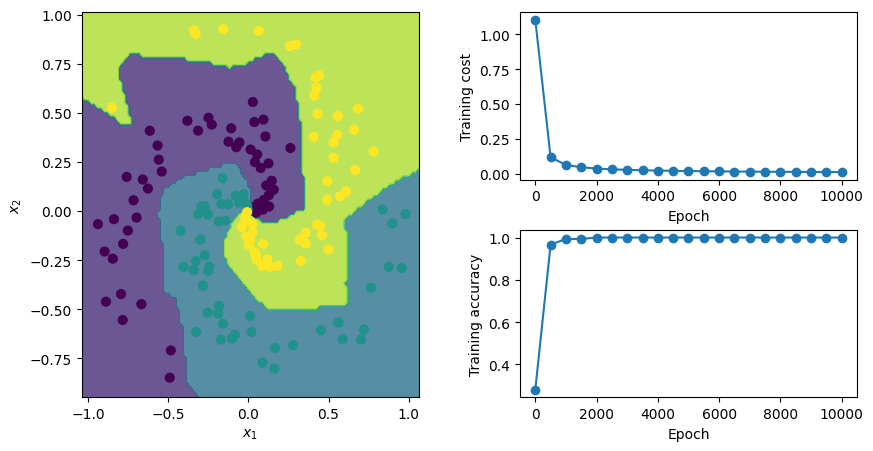

In [15]:

class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()
        self.linear1 = torch.nn.Linear(input_size, hidden_size)
        self.relu = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(hidden_size, output_size)
        self.sigmoid = torch.nn.Sigmoid()
        self.softmax = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

# Define the arguments
N_epochs = 10000
learning_rate = 1
dynamicPlotting_YesOrNo = 1
input_size = 2
output_size = K

# Define the size of the hidden layer
hidden_size = 64  # Example hidden layer size

# Initialize the model with hidden layer size
model = FeedforwardNN(input_size, hidden_size, output_size)

# Train the model for several epochs
cost_trainedNN, accuracy_trainedNN = training(model, x_train, t_train, t_onehot, N_epochs, learning_rate, dynamicPlotting_YesOrNo)

# Save the plot
plt.savefig('spiral_results.pdf', bbox_inches="tight", dpi=500)

# Print final training cost and accuracy
print("Final Training cost %f\nFinal Training accuracy %f\n" % (cost_trainedNN, accuracy_trainedNN))



In [16]:
#Run this cell if you want to save a pdf plot of the results:
files.download('spiral_results.pdf') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Studying the Effect of Hyperparameter Changes: **mag_noise**

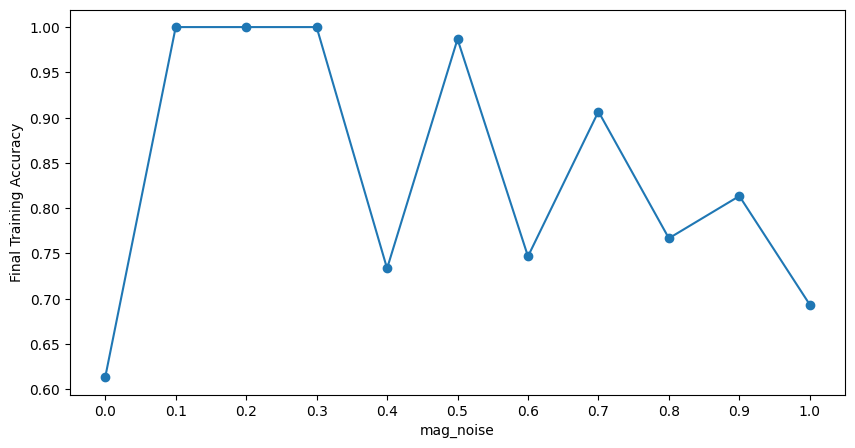

In [20]:
## Here our goal is to plot the Final Training Accuracy of the trained neural network as a function of changing mag_noise

########### mag_noise #############

### Define an array of mag_noise values ###
mag_noise_min = 0
mag_noise_max = 1.1
mag_noise_delta = 0.1 # difference between successive mag_noise values
mag_noise_values = np.arange(mag_noise_min,mag_noise_max,mag_noise_delta) # generate the array of mag_noise values

# Define hidden_size
hidden_size = 10

### Redefine other constants we need, for reference ###
N = 50 # data points per branch
# mag_noise = 0.3 #Uncomment if mag_noise is constant and you wish to change another hyperparameter instead
K = 3  # number of branches
dTheta = 4 # difference in angle per branch
N_epochs = 20000 # We choose this number to be large enough to ensure training converges for all values of mag_noise we want to test
learning_rate = 1
dynamicPlotting_YesOrNo = 1 # Show the Cost vs Epochs, Accuracy vs Epochs plots as they get updated at every value of mag_noise.
                            # Setting this to 0 will speed up the simulation when you run loop through the different noise values,
                            # but then again setting it to 1 will allow you to see how each training process is unfolding and if
                            # N_epochs epochs is large enough to achieve convergence at each value of mag_noise.
                            # ...
                            # It is important to know if the chosen N_epochs value is large enough to achieve convergence at the
                            # various values of mag_noise

### Loop through mag_noise values ###
cost_trainedNN_values = []
accuracy_trainedNN_values = []
for mag_noise in mag_noise_values:
    x_train, t_train = dataGeneration(N,K,mag_noise,dTheta)

    ### Store the input data as a PyTorch tensor ###
    x_train = torch.tensor(x_train, dtype = torch.float)

    ### One hot encoding ###
    t_onehot = np.zeros((t_train.size, K))
    t_onehot[np.arange(t_train.size),t_train] = 1
    t_onehot = torch.tensor(t_onehot, dtype = torch.float)

    ### Initialize the model ###
    input_size = 2 # dimension of input
    output_size = K # dimension of output
    '''Q2f: when you do part(f) your NN should have a hidden layer, so define the hidden layer size here such that it can
            be used as an argument to FeedforwardNN() below'''
    
    '''Q2f: include the size of the hidden layer as an argument to the FeedforwardNN() class'''
    model = FeedforwardNN(input_size, hidden_size, output_size) 

    ### Training ###
    cost_trainedNN, accuracy_trainedNN = training(model,x_train,t_train,t_onehot,N_epochs,learning_rate,dynamicPlotting_YesOrNo)

    ### Store cost and accuracy values ###
    cost_trainedNN_values.append(cost_trainedNN)
    accuracy_trainedNN_values.append(accuracy_trainedNN)

### Create Plot of accuracy (of trained NN) vs mag_noise ###
plt.clf()
fig = plt.figure(2,figsize=(5,5))
plt.plot(mag_noise_values,accuracy_trainedNN_values,'o-')
plt.xticks(mag_noise_values)
plt.xlabel('mag_noise')
plt.ylabel('Final Training Accuracy')
plt.savefig('trainedNNaccuracy_vs_magNoise.pdf', bbox_inches="tight",dpi=500)
plt.show()

In [21]:
#Run this cell if you want to save a pdf plot of the results:
files.download('trainedNNaccuracy_vs_magNoise.pdf') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Studying the Effect of Hyperparameter Changes: **hidden_size**

<Figure size 1000x500 with 0 Axes>

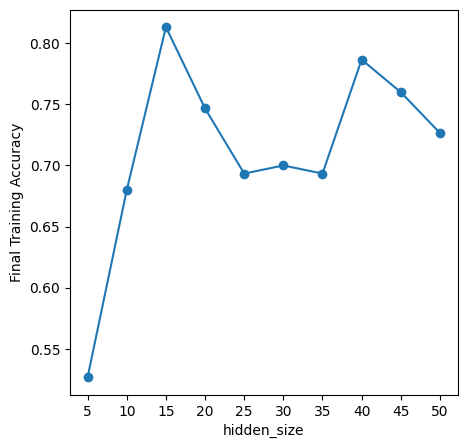

In [22]:
## Here our goal is to plot the Final Training Accuracy of the trained neural network as a function of changing hidden_size (num of hidden neurons)

# Define the FeedforwardNN class with a hidden layer size argument
class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()
        self.hidden_layer = torch.nn.Linear(input_size, hidden_size)
        self.output_layer = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        return x

# Define dataGeneration function and training function

# Define constants
N = 50 # data points per branch
K = 3  # number of branches
dTheta = 4 # difference in angle per branch
N_epochs = 20000 # number of epochs
learning_rate = 1
dynamicPlotting_YesOrNo = 1

# Define array of hidden_size values
hidden_size_min = 5
hidden_size_max = 50
hidden_size_delta = 5
hidden_size_values = np.arange(hidden_size_min, hidden_size_max + 1, hidden_size_delta)

# Loop through hidden_size values
cost_trainedNN_values = []
accuracy_trainedNN_values = []
for hidden_size in hidden_size_values:
    x_train, t_train = dataGeneration(N, K, mag_noise, dTheta)

    # Store the input data as a PyTorch tensor
    x_train = torch.tensor(x_train, dtype=torch.float)

    # One hot encoding
    t_onehot = np.zeros((t_train.size, K))
    t_onehot[np.arange(t_train.size), t_train] = 1
    t_onehot = torch.tensor(t_onehot, dtype=torch.float)

    # Initialize the model
    input_size = 2
    output_size = K
    model = FeedforwardNN(input_size, hidden_size, output_size)

    # Training
    cost_trainedNN, accuracy_trainedNN = training(model, x_train, t_train, t_onehot, N_epochs, learning_rate, dynamicPlotting_YesOrNo)

    # Store cost and accuracy values
    cost_trainedNN_values.append(cost_trainedNN)
    accuracy_trainedNN_values.append(accuracy_trainedNN)

# Create plot of accuracy (of trained NN) vs hidden_size
plt.clf()
fig = plt.figure(3,figsize=(5,5))
plt.plot(hidden_size_values, accuracy_trainedNN_values, 'o-')
plt.xticks(hidden_size_values)
plt.xlabel('hidden_size')
plt.ylabel('Final Training Accuracy')
plt.savefig('trainedNNaccuracy_vs_hiddenSize.pdf', bbox_inches="tight",dpi=500)
plt.show()


In [23]:
#Run this cell if you want to save a pdf plot of the results:
files.download('trainedNNaccuracy_vs_hiddenSize.pdf') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Studying the Effect of Hyperparameter Changes: **K** (BONUS)

<Figure size 1000x500 with 0 Axes>

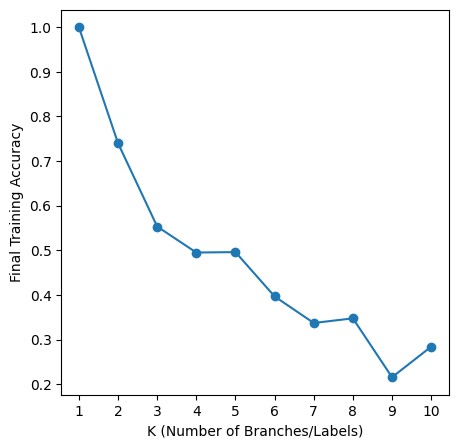

In [24]:
## Here our goal is to plot the Final Training Accuracy of the trained neural network as a function of changing K (number of branches/labels)

########### K #############

'''
Q2f: copy paste the above code for mag_noise below and tweak/modify it to be able to plot accuracy (of the trained NN) vs K instead

NOTE: for this problem, make sure to set the minimum value of K you will test to 1 (one) and not to 0 (zero), because having 0 branches makes no
      sense and will cause an error when you run it.
'''

import numpy as np
import torch
import matplotlib.pyplot as plt

# Define the FeedforwardNN class with a hidden layer size argument
class FeedforwardNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(FeedforwardNN, self).__init__()
        self.hidden_layer = torch.nn.Linear(input_size, hidden_size)
        self.output_layer = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.hidden_layer(x))
        x = self.output_layer(x)
        return x

# Define dataGeneration function and training function

# Define constants
N = 50 # data points per branch
K_min = 1 # minimum number of branches
K_max = 10  # maximum number of branches
dTheta = 4 # difference in angle per branch
N_epochs = 20000 # number of epochs
learning_rate = 1
dynamicPlotting_YesOrNo = 1

# Define array of K values
K_values = np.arange(K_min, K_max + 1)

# Loop through K values
cost_trainedNN_values = []
accuracy_trainedNN_values = []
for K in K_values:
    x_train, t_train = dataGeneration(N, K, mag_noise, dTheta)

    # Store the input data as a PyTorch tensor
    x_train = torch.tensor(x_train, dtype=torch.float)

    # One hot encoding
    t_onehot = np.zeros((t_train.size, K))
    t_onehot[np.arange(t_train.size), t_train] = 1
    t_onehot = torch.tensor(t_onehot, dtype=torch.float)

    # Initialize the model
    input_size = 2
    hidden_size = 10
    output_size = K
    model = FeedforwardNN(input_size, hidden_size, output_size)

    # Training
    cost_trainedNN, accuracy_trainedNN = training(model, x_train, t_train, t_onehot, N_epochs, learning_rate, dynamicPlotting_YesOrNo)

    # Store cost and accuracy values
    cost_trainedNN_values.append(cost_trainedNN)
    accuracy_trainedNN_values.append(accuracy_trainedNN)

# Create plot of accuracy (of trained NN) vs K
plt.clf()
fig = plt.figure(3,figsize=(5,5))
plt.plot(K_values, accuracy_trainedNN_values, 'o-')
plt.xticks(K_values)
plt.xlabel('K (Number of Branches/Labels)')
plt.ylabel('Final Training Accuracy')
plt.savefig('trainedNNaccuracy_vs_K.pdf', bbox_inches="tight",dpi=500)
plt.show()


In [25]:
#Run this cell if you want to save a pdf plot of the results:
files.download('trainedNNaccuracy_vs_K.pdf') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>